## Demo for project 1

In [ ]:
import torch
import torchvision

### Define dataset and dataloader

In [ ]:
%load_ext autoreload
%autoreload 2

from dataset import load_dataset

trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=0)
testset = load_dataset(train=False)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Check dataset and dataloader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # The data need to be normalized and unnormalized to keep the same
    # img = img / 255
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, targets = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print(names)
for i in range(batch_size):
    target_np = torch.argmax(targets[i], dim=0).cpu().numpy()
    plt.subplot(1,batch_size,i+1)
    
    plt.imshow(target_np,cmap='gray')


### Q1: Domain generalization example.

In [ ]:
from dataset import domain_generization, load_dataset
# trainset_temp, _ = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
trainset_temp, _ = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
original_image, _ = trainset_temp.__getitem__(0) # Use the first image in training set.
original_image = original_image / 2 + 0.5
original_image = original_image.numpy()
scaling_factor = 0.03 # 替换低频区域所占大小
ratio = 1 #替换区域中目标域图片的幅度比重 
num_generalized=10
# domains = ['domain1','domain2','domain3'] # 可选：'random'（默认随机选择domain）, 'domain1', 'domain2', 'domain3'.
domains = [1,2,3] # 可选：'random'（默认随机选择domain）, 'domain1', 'domain2', 'domain3'.
original_image_freq = np.fft.fftshift(np.fft.fft2(original_image,axes=(-2,-1)),axes=(-2,-1))
original_image_freq = np.log(np.abs(original_image_freq))/np.max(np.log(np.abs(original_image_freq))) # log and normalize
plt.figure(figsize=[4,2])
plt.subplot(1,2,1), plt.imshow(np.transpose(original_image, (1, 2, 0))), plt.xlabel('Raw Image.')
plt.subplot(1,2,2), plt.imshow(np.transpose(original_image_freq, (1, 2, 0))), plt.xlabel('Raw Image (frequency).')
dg_outputs_domains = []
for domain in domains:
    dg_outputs, dg_fre_outputs= np.array(domain_generization(original_image,scaling_factor, ratio,num_generalized,domain)) # 输出是一个float, 因为计算傅里叶变换的时候应该用float提高精度
    dg_outputs = np.real(dg_outputs)
    fig, axs = plt.subplots(2, num_generalized, figsize=(2*num_generalized, 2*2), layout="constrained")
    for i in range(num_generalized):
        dg_output = dg_outputs[i]
        dg_fre_output = dg_fre_outputs[i]
        dg_fre_output = np.log(np.abs(dg_fre_output))/np.max(np.log(np.abs(dg_fre_output))) # log and normalize
        axs[0,i].imshow(np.clip(np.transpose(dg_output, (1, 2, 0)),0,1)) # 转回int才可以直接imshow
        axs[0,i].set_xlabel('After DG (image).')
        axs[1,i].imshow(np.clip(np.transpose(dg_fre_output,(1,2,0)),0,1),cmap='gray')
        axs[1,i].set_xlabel('After DG (frequency).')
    plt.suptitle('Domain generalization example: {}.'.format(domain))
    dg_outputs_domains.append(dg_outputs)

In [ ]:
from dis_rep import norm_dist,PSNR_metric,SSIM_metric,CS_dist,intra_cluster_distance,inter_cluster_diatance
D_norm = np.zeros((3,3))
D_CS = np.zeros((3,3))
D_PSNR = np.zeros((3,3))
D_SSIM = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i == j:
            D_norm[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=norm_dist,ord=None)
            D_CS[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=CS_dist)
            D_PSNR[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=PSNR_metric)
            D_SSIM[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=SSIM_metric)
        else:
            D_norm[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=norm_dist,ord=None)[0]
            D_CS[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=CS_dist)[0]
            D_PSNR[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=PSNR_metric)[0]
            D_SSIM[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=SSIM_metric)[0]
print('Distances between 3 domains (norm):')
print(D_norm)
print('Distances between 3 domains (CS):')
print(D_CS)
print('Distances between 3 domains (PSNR):')
print(D_PSNR)
print('Distances between 3 domains (SSIM):')
print(D_SSIM)
def rgb2gray(rgb):
    r, g, b = rgb[:,0,:,:], rgb[:,1,:,:], rgb[:,2,:,:] # N * C * H * W
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
domain1_gray = rgb2gray(dg_outputs_domains[0])
domain2_gray = rgb2gray(dg_outputs_domains[1])
domain3_gray = rgb2gray(dg_outputs_domains[2])
domain1_gray_average = np.mean(domain1_gray,axis=0)
domain2_gray_average = np.mean(domain2_gray,axis=0)
domain3_gray_average = np.mean(domain3_gray,axis=0)
histogram1, bin_edges1 = np.histogram(domain1_gray_average, bins=256, range=(-0.5, 0.5))
histogram2, bin_edges2 = np.histogram(domain2_gray_average, bins=256, range=(-0.5, 0.5))
histogram3, bin_edges3 = np.histogram(domain3_gray_average, bins=256, range=(-0.5, 0.5))
plt.figure(figsize=(5,4))
plt.title("Grayscale Histograms")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.plot(bin_edges1[0:-1], histogram1,'r', bin_edges2[0:-1], histogram2, 'g', bin_edges3[0:-1], histogram3, 'b')
plt.figlegend(["domain1","domain2","domain3"],loc='upper right')
plt.grid(False)



In [ ]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

domain_gray = np.concatenate((np.reshape(domain1_gray,(10,-1)),np.reshape(domain2_gray,(10,-1)),np.reshape(domain3_gray,(10,-1))),axis=0)
domain_label = np.concatenate((np.ones(10),2*np.ones(10),3*np.ones(10)))
original_image_gray = 0.2989 * original_image[0,:,:] + 0.5870 * original_image[1,:,:] + 0.1140 * original_image[0,:,:]
original_image_gray = np.reshape(original_image_gray,(1,-1))
X = np.concatenate((domain_gray,original_image_gray),axis=0)
Y = np.concatenate((domain_label,np.zeros(1)),axis=0)
digits_proj = TSNE(n_components=2,perplexity=3).fit_transform(X)
 
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))
    f = plt.figure(figsize=(6, 6))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # ax.axis('off')
    ax.axis('tight')
    for i in range(4):
        if i == 0:
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, "original image")
        else:
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, "domain"+str(i), fontsize=24)
            txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
scatter(digits_proj, Y)
plt.show()

### Domain Generalization with frequency domain:

100%|██████████| 100/100 [00:00<00:00, 128896.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


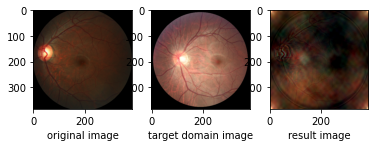

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from dataset import domain_generization, load_dataset
# trainset_temp, _ = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
trainset_temp, _ = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)

import matplotlib.pyplot as plt
import numpy as np
original_image, _ = trainset_temp.__getitem__(0) # Use the first image in training set.
original_image = original_image / 2 + 0.5
original_image = original_image.numpy()
scaling_factor = 0.03 # 替换低频区域所占大小
ratio = 1 #替换区域中目标域图片的幅度比重 

# Low frequency test
result_image,_,domain_image = domain_generization(original_image= original_image,scaling_factor=0.1,is_return_Domain=True,is_Amplitude=False)

result_image = result_image[0]
# Result Plot
plt.figure()
plt.subplot(1,3,1)
plt.imshow(np.transpose(original_image, (1, 2, 0)))
plt.xlabel("original image")

plt.subplot(1,3,2)
plt.imshow(np.transpose(domain_image, (1, 2, 0)))
plt.xlabel("target domain image")
plt.subplot(1,3,3)
plt.imshow(np.transpose(result_image, (1, 2, 0)))
plt.xlabel("result image")

plt.show()




### Define loss function and optimizer

In [ ]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self,weight=None,size_average = True):
        super(DiceBCELoss, self).__init__()
    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        Dice_BCE = 0
        for i in range(2):
            a = inputs[:,i].view(batch_number,-1)
            b = targets[:,i].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            Dice_BCE += dice_loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = Dice_BCE + BCE
        return Dice_BCE

### Define a model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import torch

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
# print(net)

In [ ]:

import torch.optim as optim
import torch.nn as nn


criterion = DiceBCELoss()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)
criterion = criterion.to(device)

### Train network

In [ ]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self,weight=None,size_average = True):
        super(DiceBCELoss, self).__init__()
    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        Dice_BCE = 0
        for i in range(1):
            a = inputs[:,i].view(batch_number,-1)
            b = targets[:,i].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            # print(dice_loss)
            Dice_BCE += dice_loss
        # Dice_BCE = Dice_BCE/2
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        # BCE = 0
        Dice_BCE = Dice_BCE + BCE
        return Dice_BCE


%load_ext autoreload
%autoreload 2

from dataset import load_dataset
import time

epoch_number = 20

for train_idx in [0]:
    """
    Train idx = 0: No DG, No DA
    Train idx = 1: DG, No DA
    Train idx = 2: No DG, DA
    Train idx = 3: DG, DA
    Train idx = 4: training for domain 1
    Train idx = 5: training for domain 2
    Train idx = 6: training for domain 3
    Train idx = 7: training for dynamic domain
    """
    

    #################### Model Define ######################
    import torch.nn as nn
    import torch.nn.functional as F
    import segmentation_models_pytorch as smp
    import torch

    net = smp.Unet(
        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )

    import torch.optim as optim
    import torch.nn as nn


    criterion = DiceBCELoss()
    # criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    net = net.to(device)
    criterion = criterion.to(device)

    #################### Model Define ######################

    if train_idx == 0:
        ############# No DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)
        PATH = ('./results/model/net_no_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/no_DG_epoch_%d.txt')%(epoch_number)
        ############# No DG #################
    elif train_idx == 1:
        # ############## DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=4)
        PATH = ('./results/model/net_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/DG_epoch_%d.txt')%(epoch_number)
        # ############## DG #################
    elif train_idx == 2:
        ############## Data argument + No DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = True,is_DG=0)
        PATH = ('./results/model/net_Data_arg_no_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_arg_no_DG_epoch_%d.txt')%(epoch_number)
        ############## Data argument + No DG #################
    elif train_idx == 3:
        # ############ Data argument +  DG #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = True,is_DG=4)
        PATH = ('./results/model/net_Data_arg_DG_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_arg_DG_epoch_%d.txt')%(epoch_number)
        # ############## Data argument +  DG #################
    elif train_idx == 4:
        # ############ Data argument +  DG + Domain 1 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=1)
        PATH = ('./results/model/net_Data_arg_DG_D1_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_arg_DG_D1_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 1 #################
    elif train_idx == 5:
        # ############ Data argument +  DG + Domain 2 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=2)
        PATH = ('./results/model/net_Data_arg_DG_D2_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_arg_DG_D2_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 2 #################
    elif train_idx == 6:
        # ############ Data argument +  DG + Domain 3 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=3)
        PATH = ('./results/model/net_Data_arg_DG_D3_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_arg_DG_D3_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 3 #################
    elif train_idx == 7:
        # ############ Data argument +  DG + Domain 1 #################
        trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=1)
        PATH = ('./results/model/net_DG_D1_epoch_%d.pth') % (epoch_number)
        log_file_name = ('./results/Loss/Data_DG_D1_epoch_%d.txt')%(epoch_number)
        # ############ Data argument +  DG + Domain 1 #################
    else:
        print("outof model bound")
        break
    

    log_file = open(log_file_name,'w')

    ########### Delete file content
    log_file.seek(0)
    log_file.truncate()
    ########### Delete file content



    batch_size = 4

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)


    for epoch in range(epoch_number):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (inputs, target) in enumerate(trainloader):
            

            inputs = inputs.to(device)
            target = target.to(device)

            outputs = net(inputs)

            loss = criterion(outputs,target)


            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            log_file.write(("%f\n") % loss.item())
            # print(("%f\n") % loss.item())
            if i % 20 == 19:    # print every 20 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0

    log_file.close()
    ################## Temp Model Save ##############
    torch.save(net.state_dict(), PATH)
    print('Finished Training')



### Validation
Note the validation set is highly related with the training set, therefore it is not wise to generate a new validation set

In [ ]:
# trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
import numpy as np
dscs = []
with torch.no_grad():
    for data in valloader:
        # print(data)
        (images, targets,names) = data
        ############ Activate this for CUDA ##################
        images = images.to(device)
        targets = targets.to(device)
        ############ Activate this for CUDA ##################
        outputs = net(images.to(torch.float32))
        
        inputs = F.sigmoid(outputs)
        batch_number = targets.size(0)
        # inputs = inputs[:,0,:,:]
        smooth = 1
        Dice_BCE = 0
        for j in range(2):
            a = inputs[:,j].view(batch_number,-1)
            b = targets[:,j].view(batch_number,-1)
            intersection = (a*b).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
            Dice_BCE += dice_loss

        dscs.append(1 - Dice_BCE.cpu().numpy()) 
dsc_test = np.mean(dscs)
print(('Dsc of validation %f')% (dsc_test))

### Save model

In [ ]:
log_file.close()
torch.save(net.state_dict(), PATH)

### Test your model performance

In [ ]:
%load_ext autoreload
%autoreload 2

import segmentation_models_pytorch as smp
from dataset import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial.distance import directed_hausdorff
from medpy import metric
import torch.nn.functional as F


nclasses = 2
epoch_number = 20
############## No DG #################    
# PATH = ('./results/model/net_no_DG_epoch_%d.pth') % (epoch_number)               # DICE loss model
# PATH = ('./results/model/net_DG_epoch_%d.pth') % (epoch_number)                  # DG result 
# PATH = ('./results/model/net_Data_arg_no_DG_epoch_%d.pth') % (epoch_number)      # DA result     
PATH = ('./results/model/net_Data_arg_DG_epoch_s03_r05_t%d.pth') % (epoch_number)  # DG + DA result
# PATH = './results/model/net_no_DG_epoch_cross_entropy_20.pth'                      # Cross entropy loss result
# PATH = ('./results/model/net_no_DG_epoch_DICE_t%d.pth') % (epoch_number)         # Dice Loss result
############## No DG #################

############## Metric Type ################
# metric_type = "DICE"
metric_type = "HD95"
# metric_type = "TA"
############## Metric Type ################

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=nclasses,                      # model output channels (number of classes in your dataset)
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)




net.load_state_dict(torch.load(PATH,map_location='cpu'))




batch_size = 4



for i in range(3):
    
    # Contruct test loader for different test region
    test_data_str = ("./data/Pro1-SegmentationData/Domain%d/data/*.bmp") % (i + 1)
    test_label_str = ("./data/Pro1-SegmentationData/Domain%d/label/{}.bmp") % (i + 1)
    if i == 0:
        test_data_str = ("./data/Pro1-SegmentationData/Domain%d/data/*.jpg") % (i + 1)
        test_label_str = ("./data/Pro1-SegmentationData/Domain%d/label/{}.png") % (i + 1)
    testset = load_dataset(train=False,test_data_str = test_data_str, test_label_str = test_label_str)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
    dscs = []
    with torch.no_grad():
        for data in testloader:
            images, targets, names = data
            ############ Activate this for CUDA ##################
            images = images.to(device)
            targets = targets.to(device)
            ############ Activate this for CUDA ##################
            outputs = net(images.to(torch.float32))
            
            if metric_type == "DICE":
                ############ DICE metric #############################
                inputs = F.sigmoid(outputs)
                batch_number = targets.size(0)
                # inputs = inputs[:,0,:,:]
                smooth = 1
                Dice_BCE = 0
                for j in range(2):
                    a = inputs[:,j].view(batch_number,-1)
                    b = targets[:,j].view(batch_number,-1)
                    intersection = (a*b).sum()
                    dice_loss = 1 - (2. * intersection + smooth) / (a.sum() + b.sum() + smooth)
                    Dice_BCE += dice_loss

                dscs.append(1 - Dice_BCE.cpu().numpy()) 
                ############ DICE metric #############################
            elif metric_type ==  "HD95":
                ############ HD 95 metric ############################
                for idx, name in enumerate(names):
                    output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
                    binary_output = np.array(output_np)
                    target_np = torch.argmax(targets[idx], dim=0).cpu().numpy()
                    # target_1d = np.reshape(target_np, (-1, 1))
                    # pred_1d = np.reshape(binary_output, (-1, 1))
                    # plt.imshow(output_np,cmap='gray')
                    # plt.show()
                    # dsc = max(directed_hausdorff(output_np,target_np)[0],directed_hausdorff(target_np,output_np)[0])
                    dsc = metric.binary.hd95(target_np,output_np)
                    dscs.append(dsc) 
                ############ HD 95 metric ############################
            elif metric_type ==  "TA":
                ########### Dice by TA ##############################
                for idx, name in enumerate(names):
                    output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
                    binary_output = np.array(output_np)
                    target_np = torch.argmax(targets[idx], dim=0).cpu().numpy()
                    target_1d = np.reshape(target_np, (-1, 1))
                    pred_1d = np.reshape(binary_output, (-1, 1))
                    # plt.imshow(output_np,cmap='gray')
                    # plt.show()
                    accuracy = accuracy_score(target_1d, pred_1d)
                    # print(accuracy)
                    if nclasses == 2:
                        dsc = f1_score(target_1d, pred_1d) # f1_score就是Dice
                    else:
                        dsc = f1_score(target_1d, pred_1d,average='micro')
                    dscs.append(dsc) 
                ########### Dice by TA ##############################
            else:
                print(("Not a valid/implemented metric %s") % metric_type)
                break
            
    dsc_test = np.mean(dscs)
    print(('Dsc of test set %d: %f')% (i + 1,dsc_test))


### Result Display

In [ ]:
# show last predicted result
import matplotlib.pyplot as plt
for i,_ in enumerate(images):
    image = images.cpu().numpy()[i]
    target_np = torch.argmax(targets[i], dim=0).cpu().numpy()
    output_np = torch.argmax(outputs[i], dim=0).cpu().numpy()
    image = image/2 + 0.5
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.subplot(1,3,2)
    plt.imshow(target_np,cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(output_np,cmap='gray')
    plt.show()